# Scroll to bottom for seismogram comparison!
# Implementation notes:
1. Global variables: Some variables previously needed to be defined globally. None do for now, but it might be cleaner if they were. Ex. all of the material properties and layer geometry
2. Numpy arrays: B and rho inputs **must be numpy arrays** because normal python array multiplication is dumb (or maybe Jes is)
3. I might be confused about the $SH_j$ part of the calculation. They define the radiation pattern, so I think they use source layer parameters.
4. The $\eta_\beta$ is taken as the slowness of the source layer. Maybe it's supposed to be the slowness of the layer the ray is in at each point but ~~ugh no~~ I hope not.
5. I haven't thought about units at all. Time is probably in units of .01 seconds right now.

# Modeling the Alum Rock M4.6 Event

The original velocity structure used with the GRT code was

    3    2 1500    0.25000001E-01
       6
   0.100000E-02   0.100000E-02   0.100000E-02   0.100000E-02   0.000000E+00
   0.550000E+01   0.220300E+01   0.240000E+01   0.450000E+01   0.000000E+00
   0.630000E+01   0.334000E+01   0.267000E+01   0.350000E+01   0.000000E+00
   0.630100E+01   0.334100E+01   0.267000E+01   0.800000E+01   0.000000E+00
   0.670000E+01   0.397000E+01   0.280000E+01   0.190000E+02   0.000000E+00
   0.780000E+01   0.400000E+01   0.330000E+01   0.400000E+03   0.000000E+00

Where:

line 1:  layer-above-source    fluid(0)-or-solid(2)    number-of-time-points   time-sample-rate
line 2:  number-of-layers
line 3+ p-velocity(km/s)  s-velocity(km/s)  density(g/cc)  thickness(km)  layer-dip(radians)

We'll use the same(ish) simple velocity model:
* Layer 1: d = 5km, B = 2.2km/s, rho = 2.4 g/cc
* Layer 2: d = 16km, B = 3.34km/s, rho = 2.67 g/cc
* Layer 3: d = 35km, B = 3.97km/s, rho = 2.8 g/cc
* Lower half-space: B = 4.0km/s, rho = 3.3 g/cc
* Source depth: d = 8km

In [21]:
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline

## Define ray functions
t_[**u**p or **d**own][**T**ransmit or **R**eflect at each layer until station]

In [8]:
def tf_uT(p1,x,zs,B):
    return p1*x + (z[0]-z[1])*np.sqrt(1/B[1]**2-p1**2) + z[1]*np.sqrt(1/B[0]**2-p1**2)
def tf_uTRR(p1,x,zs,B):
    return p1*x + (z[0]-z[1])*np.sqrt(1/B[1]**2-p1**2) + 3*z[1]*np.sqrt(1/B[0]**2-p1**2)
def tf_uTRRRR(p1,x,zs,B):
    return p1*x + (z[0]-z[1])*np.sqrt(1/B[1]**2-p1**2) + 5*z[1]*np.sqrt(1/B[0]**2-p1**2)
def tf_dRT(p1,x,zs,B):
    return p1*x + (2*z[2]-z[0]-z[1])*np.sqrt(1/B[1]**2-p1**2) + z[1]*np.sqrt(1/B[0]**2-p1**2)
def tf_dTRTT(p1,x,zs,B):
    return p1*x + 2*(z[3]-z[2])*np.sqrt(1/B[2]**2-p1**2) + 2*(z[2]-z[1])*np.sqrt(1/B[1]**2-p1**2) + z[1]*np.sqrt(1/B[0]**2-p1**2)


## Define p-finding function

In [9]:
def t_from_p(x, zs, B, tfunc, tmax):
    p = [0*1j]
    t = [tfunc(p[0],x,zs,B).real]
    
    while t[-1] < tmax:
        w0 = p[-1].real
        y0 = p[-1].imag
        coords = []
        for theta in range(0,90):
            th = theta*np.pi/180
            w = w0 + np.cos(th)*.0005
            y = y0 + np.sin(th)*.0005
            coords.append((w,y))
        tvals = [tfunc(complex(*coord),x,zs,B) for coord in coords]
        t_ind = np.argmax([tv.real for tv in tvals])
        t.append(tvals[t_ind].real)
        p.append(complex(*coords[t_ind]))
    
    return t, np.array(p)

## Condense dp/dt interpolation

In [10]:
def get_dpdt(t,p):
    dt = .01 #IF CHANGING: also change dt in material parameters block
    f=interp1d(t,p)
    t_0 = np.ceil(t[0]/dt)*dt #round t[0] up to nearest dt unit
    xi=np.arange(t_0,np.floor(t[-1]),dt)
    yi = f(xi)
    stub = np.arange(0,t_0,dt) #interpolation points between t=0 and t_0
    dpdt = np.diff(yi)/dt
    dpdt = np.concatenate((np.ones(len(stub))*dpdt[0],dpdt)) #fill with dpdt[0]s in case not quite = 0
    yi = np.concatenate((np.zeros(len(stub)),yi)) #fill with zeros back to t=0
    return yi,dpdt

## Define ray-processing functions
Output ${\rm Im}\left (\frac{\sqrt p}{\eta} SH_j(p) \Pi(p) p \frac{dp}{dt}\right )$, where $SH_j$ are the radiation patterns and $\Pi$ is the product of reflection and transmission coefficients, for each ray. Note that SH1 and SH2 are equivalent to tds and tss in EPS 207.

$SH_1 = 1/\beta^2$ and $SH_2 = \frac{\varepsilon}{\beta^2}\frac{\eta}{p}$ where $\varepsilon$ is +1 for upgoing and -1 for downgoing rays.

In [11]:
def i_uT(t,p,B,rh):
    yi,dpdt = get_dpdt(t,p) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(np.sqrt(yi[:-1])*Tr*dpdt/B[1]**2)
    return SH1,SH2
def i_uTRR(t,p,B,rh):
    yi,dpdt = get_dpdt(t,p) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Re = (mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)-mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2)
         )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr*Re*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(np.sqrt(yi[:-1])*Tr*Re*dpdt/B[1]**2)
    return SH1,SH2
def i_uTRRRR(t,p,B,rh):
    yi,dpdt = get_dpdt(t,p) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Re = (mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)-mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2)
         )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr*Re*Re*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(np.sqrt(yi[:-1])*Tr*Re*Re*dpdt/B[1]**2)
    return SH1,SH2
def i_dRT(t,p,B,rh):
    yi,dpdt = get_dpdt(t,p) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Re = (mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2)-mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2)
         )/(mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2)+mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr*Re*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(-1*np.sqrt(yi[:-1])*Tr*Re*dpdt/B[1]**2)
    return SH1,SH2
def i_dTRTT(t,p,B,rh):
    yi,dpdt = get_dpdt(t,p) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr_10 = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Tr_12 = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Tr_21 = 2*mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2
                        )/(mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Re = (mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2)-mu[3]*np.sqrt(1/B[3]**2-yi[:-1]**2)
         )/(mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2)+mu[3]*np.sqrt(1/B[3]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr_12*Re*Tr_21*Tr_10*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(-1*np.sqrt(yi[:-1])*Tr_12*Re*Tr_21*Tr_10*dpdt/B[1]**2)
    return SH1,SH2

## Calculate Synthetic seismogram with radiation pattern and source time function (Helmberger Eqn2.33)
The SH solution on a free boundary is defined as $V = \frac{M_0}{4\pi\rho_0}\frac{d}{dt}[\dot{D(t)} * \Sigma^{2}_{j=1} A_{j+3}(\theta,\lambda,\delta)V_j(t)]$, where $V_j(t) = \sqrt{2/r}\frac{1}{\pi}[\frac{1}{\sqrt{t}}*SH_j]$. $M_0$ is the scalar seismic moment (units of dyne-cm...default is $10^{20}$ dyne-cm); $\dot{D(t)}$ is the source time function (e.g., triangle; Brune); $A_{j+3}(\theta,\lambda,\delta)$ are the coefficients describing the relative weight of the transverse vertical strike-slip (tss) and dip-slip (tds) fundamental-faults, which depend on fauilt dip ($\delta$), rake ($\lambda$), and angle between station and strike of fault ($\theta$).

In [34]:
def Vt(t,r,SH):
    A1=np.pi*np.pi/16;
    sdt=2.0/np.sqrt(dt);
    a=0;
    m = len(t)
    rt = np.zeros((m,1))[:,0]
    for I in range(0,m):
         b=np.sqrt((I) + A1)
         rt[I]=sdt * (b - a)
         a = b
    return (np.sqrt(2/(r))/np.pi)*np.convolve(rt,SH)

def scaleMoment(M0,x,beta,rh):
    return M0*2/np.pi*np.sqrt(2/x)*1/(beta**2)*1/(4*np.pi*rh)

def radiationPattern(azimuth,strike,dip,rake):
    theta=azimuth-strike;
    theta=theta*np.pi/180;
    rake=rake*np.pi/180;
    dip=dip*np.pi/180;
    A4=np.cos(2*theta)*np.cos(rake)*np.sin(dip)-0.5*np.sin(2*theta)*np.sin(rake)*np.sin(2*dip);
    A5=-1*np.sin(theta)*np.cos(rake)*np.cos(dip)-np.cos(theta)*np.sin(rake)*np.cos(2*dip);
    return A4,A5

def synth_sourcetime(A4,A5,M0,Vt_SH1,Vt_SH2,risetime,dt,rh):
    def synth():
        s = np.diff((A4*Vt_SH1 + A5*Vt_SH2))/dt
        return M0*s
    def makeDdot():
        time=np.arange(0,risetime*3,dt)
        sourceTimeFn=time*np.e**(-time/(risetime/4.0))
        return sourceTimeFn/np.trapz(sourceTimeFn)

    return np.convolve(makeDdot(),synth())

In [35]:
# def synth_sourcetime(A4,A5,M0,Vt_SH1,Vt_SH2,risetime,dt,rh):
#     w5=conv(rt,u).*dt;
#     wds5=conv(rt,uds).*dt;
    
#     dw5=diff(w5)./dt;
#     dwds5=diff(wds5)./dt;

#     tss=np.convolve(src,tss)*dt
#     tds=np.convolve(src,tds)*dt
#     return M0*(A4*tss + A5*tds)

# def Vt(t,r,SH):
#     A1=np.pi*np.pi/16;
#     sdt=2.0/np.sqrt(dt);
#     a=0;
#     m = len(t)
#     rt = np.zeros((m,1))[:,0]
#     for I in range(0,m):
#          b=np.sqrt((I) + A1)
#          rt[I]=sdt * (b - a)
#          a = b
#     return np.sqrt(2/(r*1e5))/np.pi*np.convolve(rt,SH)

#### Compute synthetic for Alum Rock

In [36]:
#put alum rock geometry and velocity and rho in here.
x = 80.05 #Station distance
z = np.array([8,5,16,35])
B = np.array([2.2,3.34,3.97,4.0])
rho = np.array([2.4,2.67,2.8,3.3])
dt = .01
azimuth=321.6;
strike=318;
dip=83;
rake=-176;
M0=9.20e2;
risetime=.5;

In [15]:
#Pick max time
tmax = 120 #seconds
#Get individual ray paths in the complex p-plane
t_uT,p_uT = t_from_p(x, z, B, tf_uT, tmax)
t_uTRR,p_uTRR = t_from_p(x, z, B, tf_uTRR, tmax)
t_uTRRRR,p_uTRRRR = t_from_p(x, z, B, tf_uTRRRR, tmax)
t_dRT,p_dRT = t_from_p(x, z, B, tf_dRT, tmax)
t_dTRTT,p_dTRTT = t_from_p(x, z, B, tf_dTRTT, tmax)

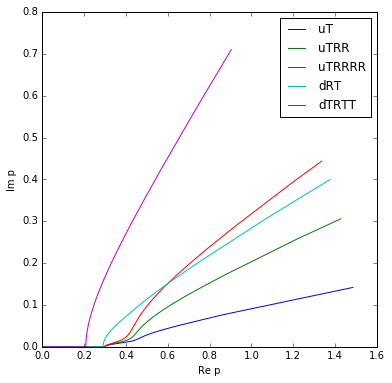

In [16]:
#Plot p-plane ray paths
fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.plot(p_uT.real,p_uT.imag,p_uTRR.real,p_uTRR.imag,p_uTRRRR.real,p_uTRRRR.imag,p_dRT.real,p_dRT.imag,p_dTRTT.real,p_dTRTT.imag)
ax.set_xlabel("Re p")
ax.set_ylabel("Im p")
ax.legend(("uT","uTRR","uTRRRR","dRT","dTRTT"))
# ax.set_xlim(right=1)
# ax.set_ylim(top=.3)

In [37]:
#Sum imaginary parts for SH1 and SH2
SH_sum = np.array(i_uT(t_uT,p_uT,B,rho))
SH_sum += np.array(i_uTRR(t_uTRR,p_uTRR,B,rho))
SH_sum += np.array(i_uTRRRR(t_uTRRRR,p_uTRRRR,B,rho))
SH_sum += np.array(i_dRT(t_dRT,p_dRT,B,rho))
SH_sum += np.array(i_dTRTT(t_dTRTT,p_dTRTT,B,rho))
# SH1,SH2 = SH_sum

#Apply radiation pattern and source time function
t = np.arange(dt,tmax,dt)
A4,A5 = radiationPattern(azimuth,strike,dip,rake)
M0=scaleMoment(M0,x,B[1],rho[1])
uSH = synth_sourcetime(A4,A5,M0,Vt(t,x,SH_sum[0,:]),Vt(t,x,SH_sum[1,:]),risetime,dt,rho) #njl

1.5615325058


(0.0, 8000)

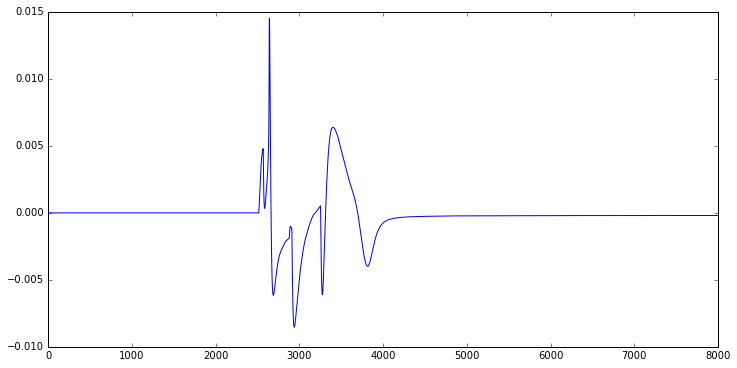

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))
ax.plot(uSH)
ax.set_xlim(right=8000)

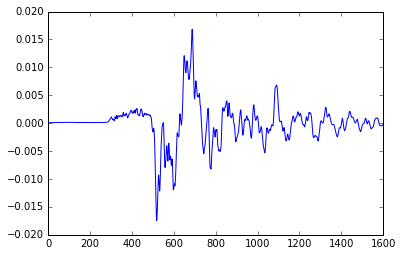

In [19]:
import matplotlib.pyplot as plt
import obspy
d=obspy.read('alumdata')
plt.plot(d[0])

In [20]:
d[0].stats

         network: 
         station: BKS
        location: 
         channel: Q
       starttime: 1993-08-11T22:33:04.091000Z
         endtime: 1993-08-11T22:34:24.091000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 1601
           calib: 0.00244141
         _format: SAC
             sac: AttribDict({'iftype': 1, 'stel': 276.0, 'depmen': 1.7200138e-05, 'depmax': 0.016833488, 'nevid': 0, 'evla': 37.313, 'cmpaz': 51.269165, 'norid': 0, 'internal1': 0.041000001, 'iztype': 11, 'lcalda': 1, 'dist': 80.051086, 'stlo': -122.235, 'unused23': 0, 'internal2': 0.050000001, 'evlo': -121.67, 'scale': 0.0024414062, 'internal3': 6000, 'kcmpnm': 'Q       ', 'ievtyp': 40, 'depmin': -0.017463746, 'kstnm': 'BKS     ', 'nzhour': 22, 'nzmin': 33, 'internal0': 1.0, 'cmpinc': 90.0, 'e': 79.990997, 'npts': 1601, 'kevnm': '932232233BHN    ', 'gcarc': 0.72000003, 'nzjday': 223, 'delta': 0.050000001, 'leven': 1, 'stla': 37.876999, 'idep': 6, 'nvhdr': 6, 'lovrok': 1, 'az': 321.61243, 'baz': 14